# Logistic regression
### By Grzegorz Rybak

### 1. Initialising the dataset

In [3]:
import numpy as np

np.random.seed(1345)

The data for this model comes from the Wikipedia's logistic regression example dataset: https://en.wikipedia.org/wiki/Logistic_regression#Probability_of_passing_an_exam_versus_hours_of_study

In [4]:
# ======== DATA LOAD ===========
X = np.asarray ([[0.50], [0.75], [1.00], [1.25], [1.50], [1.75], [3.00], [4.75],[1.75], [3.25], [5.00],[2.00], [2.25], [2.50], [2.75], [3.50], [4.00], [4.25], [4.50], [5.50]])

y= np.asarray([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,0,1,0,1,1,1,1,1,1])

In [5]:
# ======= Shuffling and composing X/y train data ===============
# We take the length of our data samples and shuffle the dataset indices
num_of_data = len(y)
indices = np.arange(0,num_of_data)
np.random.shuffle(indices)

X_train = X[indices]
y_train = y[indices]
y_train = y_train.reshape(-1,1) 

In [6]:
# ============== (OPTIONAL) Split data to train/test =============================
# IDEA: Arbitrarily take 80% as our training data and 20% as test data. 
# NOTE: this is optional and for the sake of our task we don't need to have the Test dataset 
# (Also because for this particular problem we don't need to do any preprocessing for the data, thus one can easily plug in any value for the "predict" feature to see the prediction of the test passed. Also, because the dataset is so small, including those 4 samples gives us 5% smaller value in the loss! )
# Feel free to uncomment the code if you otherwise wish to have the train/test split. 
# holdout_rate = int(num_of_data*.2)
# train_data_indices = indices[:-holdout_rate] 
# test_data_indices = indices[-holdout_rate:]

# X_train = X[train_data_indices]
# X_test = X[test_data_indices]

# Split the targets into training/testing sets
# y_train = y[train_data_indices]
# y_test = y[test_data_indices]

# y_train = y_train.reshape(-1,1) 
# y_test = y_test.reshape(-1,1)

### 2. Logistic Regression  

Disclaimer: please note the following logistic regression code was heavily inspired by an implementation of the logistic regression for the Iris dataset found here: https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f

In [24]:
# ============ LOGISTIC REGRESSION =============
class LogisticRegression():
    def __init__(self, no_max_epochs:bool = False, num_of_max_epochs:int=1000000, learning_rate:float = 0.001, epsilon:float =0.005, **kwargs):
        self.no_max_epochs = no_max_epochs
        self.num_of_max_epochs = num_of_max_epochs
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.saved_loss_values = []
        # IDEA: Adding "**kwargs" allows to easily add other params to the class from here in future class versions without breaking changes (like class call args order)
        # .... (future optional params obtained through **kwargs )  
        # Initialise variables for needed for later

    def predict(self, input_x):
        try:
            z = np.matmul(input_x, self.W) + self.b
            prediction = self.sigmoid(z)
            return self.decision_boundary(prediction)
        except AttributeError:
            print('You can only call predict method AFTER the fit method.')
        

    def fit(self,x, y, **kwargs):
        self.x = x
        self.y = y
        # This if for convenience only, if one decides to provide these methods at the fitting level instead of the initialisation level, we override these settings initialised at the class instantiation. 
        if 'num_of_max_epochs' in kwargs:
            self.num_of_max_epochs = kwargs['num_of_max_epochs']
        if 'no_max_epochs' in kwargs and type(kwargs['no_max_epochs']) is bool:
            self.no_max_epochs = kwargs['no_max_epochs']
        # ========== Fit: initialisation part ============================
        # bias, weight & learning rate initialisation 
        last_dim_shape = x.shape[-1]
        # IDEA: W is "Weights", weights represent Thetas(θj). 
        # the number of Thetas (θ1,θ2,..θn, excluding the θ0) depends on the number of features of the each datapoint 
        # in the X dataset. In the study/result example, there is only 1 theta (θ1, again, not counting θ0) as the 
        # shape of Data is (20,1) (twenty samples, 1 feature each), whereas the Iris dataset would have 4 Thetas 
        # because of shape (150,4)   
        W = np.zeros((last_dim_shape,1))
        # IDEA: b is "Bias", Bias represents the Theta0 (θ0) - as the x0 is 1 then the theta0 is always an array.shape == (1,1)  
        b = np.zeros((1,1))
        lr = self.learning_rate

        m = len(y) #i.e. num of all data in training 

        # IDEA: Initialise the "old_loss" variable with arbitrarily huge loss. 
        # This will be used to compare every 5 epochs with the newest loss to see the loss converged.
        old_loss = 1000
        # IDEA: Epsilon will be used in determining if the loss has converged; If the difference between the old_loss and current loss will be smaller or equal to epsilon, we will treat the gradient decent to converged. 
        _epsilon = self.epsilon

        # ============= Fit: Gradient Decent part =========================

        epoch = 0
        # "While True" -> Until our loss doesn't converge... 
        while True:
            # Disclaimer: the following 8 lines of code heavily follow the code found in the article
            #  provided in the disclaimer at the beginning of the section.              
            Z = np.matmul(x, W) + b
            prediction = self.sigmoid(Z)
            loss = self.loss_function(y,prediction)
            delta_Z = prediction - y
            delta_W = 1/m *  np.matmul( x.T , delta_Z )
            delta_b = np.sum(delta_Z)

            W = W - lr * delta_W
            b = b - lr * delta_b

            # Every epoch save the loss value.             
            self.saved_loss_values.append(loss)
            # IDEA: Only after 50000 we start checking if the function converged...
            if epoch > 100:
                # IDEA: Every odd 5 epochs we save the "old loss"... 
                if epoch % 5 == 0 and epoch % 10 != 0 : 
                    old_loss = loss
                # Then, every "10th" epoch check if the "old_loss" from 5 epochs before matches 
                # with the newest loss (to have bigger confidence in results, I check 5 losses "away" instead of ones directy after each other) 
                if epoch % 10 == 0:
                    if self.has_converged(old_loss, loss, _epsilon):
                        break
            if  self.no_max_epochs is not None and epoch > self.num_of_max_epochs:
                break
            epoch += 1

        # =========== Fit: Save results withing the class ===========
        self.Z = Z
        self.W = W 
        self.b = b
        self.epochs_executed = epoch
        self.train_predictions = prediction
        print(f"Fitting completed on epoch:{epoch}")
        return prediction, self.saved_loss_values

    def print_saved_loss(self):
        for val in self.saved_loss_values:
            print (val)

    def print_train_data_predictions(self):
        try:
            for prediction,true_label,study_time in zip(self.train_predictions, self.y, self.x):
                y_pred = self.decision_boundary(prediction)
                print(f' Study time: {study_time} | Predicted: {y_pred} | Actual: {true_label} ' )
        except AttributeError:
            print('You can only call this method AFTER the fit method.')

    def print_trained_parameter_values(self):
        print (f'"trained" bias (theta 0): {self.b} ')
        print ('"trained" weights (thetas 1,2..n):')
        for weight, index in enumerate(self.W, 1):
            print(f"weight (theta) {index}: {weight} ", end = '')
            

    @staticmethod 
    def sigmoid(z):
        return 1/(1 + np.e**(-z) )

    @staticmethod 
    def loss_function(y, y_pred):
        return -np.mean(y * np.log(y_pred) \
            + (1-y) * np.log(1 - y_pred ) )

    @staticmethod
    def has_converged(old_loss,new_loss, epsilon):
        if old_loss - new_loss <= epsilon:
            return True
        return False
    @staticmethod
    def decision_boundary(prediction):
        if prediction >= 0.5:
            return 1 
        else:
            return 0 

### 3. Run the logistic regression on "study_time/exam_result" dataset 

In [8]:
# ========= Fit the data and run it all ==================
logReg = LogisticRegression()
predictions, saved_loss_vals = logReg.fit(X_train,y_train)

Fitting completed on epoch:50010


### 4. Results Analysis  

In [9]:
logReg.print_train_data_predictions()

 Study time: [1.75] | Predicted: 0 | Actual: [1] 
 Study time: [1.25] | Predicted: 0 | Actual: [0] 
 Study time: [5.] | Predicted: 1 | Actual: [1] 
 Study time: [2.5] | Predicted: 0 | Actual: [0] 
 Study time: [4.25] | Predicted: 1 | Actual: [1] 
 Study time: [4.] | Predicted: 1 | Actual: [1] 
 Study time: [4.75] | Predicted: 1 | Actual: [0] 
 Study time: [2.] | Predicted: 0 | Actual: [0] 
 Study time: [2.25] | Predicted: 0 | Actual: [1] 
 Study time: [1.5] | Predicted: 0 | Actual: [0] 
 Study time: [2.75] | Predicted: 1 | Actual: [1] 
 Study time: [0.75] | Predicted: 0 | Actual: [0] 
 Study time: [4.5] | Predicted: 1 | Actual: [1] 
 Study time: [5.5] | Predicted: 1 | Actual: [1] 
 Study time: [3.25] | Predicted: 1 | Actual: [0] 
 Study time: [3.5] | Predicted: 1 | Actual: [1] 
 Study time: [0.5] | Predicted: 0 | Actual: [0] 
 Study time: [1.75] | Predicted: 0 | Actual: [0] 
 Study time: [3.] | Predicted: 1 | Actual: [1] 
 Study time: [1.] | Predicted: 0 | Actual: [0] 


#### 4.1 Plotting the results  

In [12]:
import matplotlib.pyplot as plt
def plotFunc(epochs_num, train_loss):
    plt.clf()  #Clear any previous plot
    label = 'Training loss'
    plt.plot(epochs_num, train_loss, 'b', label =label)
    plt.xlabel('Epochs')
    plt.title("Training loss")
    plt.ylabel('Loss')
    plt.legend()

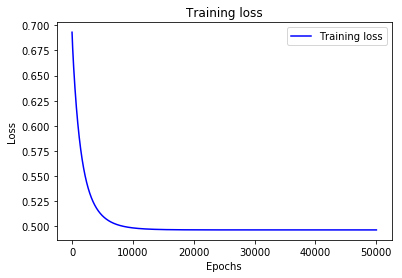

In [14]:
num_of_epochs = logReg.epochs_executed
epochs_formatted = [i for i in range(num_of_epochs)]
loss_values = saved_loss_vals
plotFunc(epochs_formatted,loss_values[:-1])

# Question II (code)

Question description: What happens if α is too large? How does this affect the loss function?Plot the loss function with respect to iterations to illustrate this point.

In [38]:
logRegWithBigAlpha = LogisticRegression(learning_rate=1)
_, saved_loss_vals = logRegWithBigAlpha.fit(X_train,y_train)

Fitting completed on epoch:110


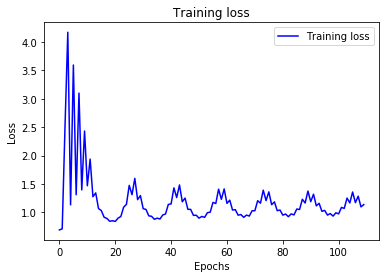

In [39]:
num_of_epochs = logRegWithBigAlpha.epochs_executed
epochs_formatted = [i for i in range(num_of_epochs)]
loss_values = saved_loss_vals
plotFunc(epochs_formatted,loss_values[:-1])

# Question 3 (pseudocode)
Question description: Assume that you are applying logistic regression to the iris (flower)
dataset.
1.  How would your hypothesis function change in this case and why?
2.  How would you utilize your implementation of logistic regression in order to
perform (multi-class) classification on the iris dataset? Include some pseudocode
while discussing your approach.
(See the report for the answers the below pseudocode supports).

In [ ]:
# .... inside the LogisticRegression class .... 
 def fit(self,x, y, **kwargs):
        last_dim_shape = x.shape[-1]
        W = np.zeros((last_dim_shape,1))
        b = np.zeros((1,1))
        lr = self.learning_rate
        m = len(y) 
        
        #  ===== Grouping method ====
        x0,y0,x1,y1,x2,y2 = [],[],[],[],[],[]
        # This would need another for loop layer to be futher generalised instead of only 3 classes in the Iris dataset.         
        for _x,_y in zip(x,y):
            if _y == 0:
                x0.append(_x)
                y0.append(_y)
            elif _y == 1:
                x1.append(_x)
                y1.append(_y)
            else:
                x2.append(_x)
                y2.append(_y)
                
        epoch = 0
        while True:
            all3Preds = []
            for class_num in range(allClasses): 
                current_x = x0 + x1 + x2
                _y[class_num] = len(y[allOther1] + y[allOther2])
                _y[class_num] = np.ones((_y)) 
                current_y = y[class_num] + _y[class_num]
                Z = np.matmul(current_x, W) + b
                _prediction = self.sigmoid(Z)
                all3Preds.append(_prediction)
            prediction = chooseTheHighestPrediction(all3Preds) #This could be another helper function. 
#           .... THEN THE REST OF THE ACTUAL CODE .... 
#             loss = self.loss_function(y,prediction)
#             delta_Z = prediction - y
#             delta_W = 1/m *  np.matmul( x.T , delta_Z )
#             delta_b = np.sum(delta_Z)

#             W = W - lr * delta_W
#             b = b - lr * delta_b

#             # Every epoch save the loss value.             
#             self.saved_loss_values.append(loss)
#             # IDEA: Only after 50000 we start checking if the function converged...
#             if epoch > 100:
#                 # IDEA: Every odd 5 epochs we save the "old loss"... 
#                 if epoch % 5 == 0 and epoch % 10 != 0 : 
#                     old_loss = loss
#                 # Then, every "10th" epoch check if the "old_loss" from 5 epochs before matches 
#                 # with the newest loss (to have bigger confidence in results, I check 5 losses "away" instead of ones directy after each other) 
#                 if epoch % 10 == 0:
#                     if self.has_converged(old_loss, loss, _epsilon):
#                         break
#             if  self.no_max_epochs is not None and epoch > self.num_of_max_epochs:
#                 break
#             epoch += 1
        